In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
from data import stock_data
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [4]:
con = sqlite3.connect("stock_data.db", check_same_thread=False)

In [24]:
stock_list=list(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", con)['name'])
stock_list

['IBM',
 'TSLA',
 'NVDA',
 'JPM',
 'BTC',
 'ETH',
 'AAPL',
 'SPY',
 'INTC',
 'AMC',
 'COIN',
 'MSFT',
 'JNJ',
 'PG']

In [8]:
def get_stock_data(stock_list):
    df_dict = {}
    for stock in stock_list:
        df = pd.read_sql(f"SELECT * FROM {stock}", con, parse_dates=['date'], index_col='date')
        df.index = pd.to_datetime(df.index, format='ISO8601')
        df.sort_index(inplace=True)
        df_dict[stock] = df
        df_dict[stock]['returns'] = np.log(df['close'] / df['close'].shift(1)) * 100
        df_dict[stock].dropna(inplace=True)
    return df_dict

In [96]:
def plot_stock_data(df,feature='close'):
    fig, ax = plt.subplots(7, 2, figsize=(12, 8))
    for i, stock in enumerate(df):
        df[stock][feature].plot(ax=ax[i//2, i%2], title=stock)
        ax[i//2, i%2].set_xlabel('Date')
        ax[i//2, i%2].set_ylabel(feature.capitalize())
        ax[i//2, i%2].grid(True)
    # plt.tight_layout()
    plt.show()

In [70]:
def plot_stock_acf(df, lags=20):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    for i, stock in enumerate(df):
        plot_acf(df[stock]['returns']**2, lags=lags, ax=ax[i//2, i%2], title=f'ACF for {stock}')
        ax[i//2, i%2].set_title(f' {stock}')
        ax[i//2, i%2].set_xlabel('Lags')
        ax[i//2, i%2].set_ylabel('ACF')
        ax[i//2, i%2].grid(True)
    plt.tight_layout()
    plt.show()

In [58]:
df_dict = get_stock_data(stock_list)

In [59]:
df_dict.keys()

dict_keys(['IBM', 'TSLA', 'NVDA', 'JPM', 'BTC', 'ETH', 'AAPL', 'SPY', 'INTC', 'AMC', 'COIN', 'MSFT', 'JNJ', 'PG'])

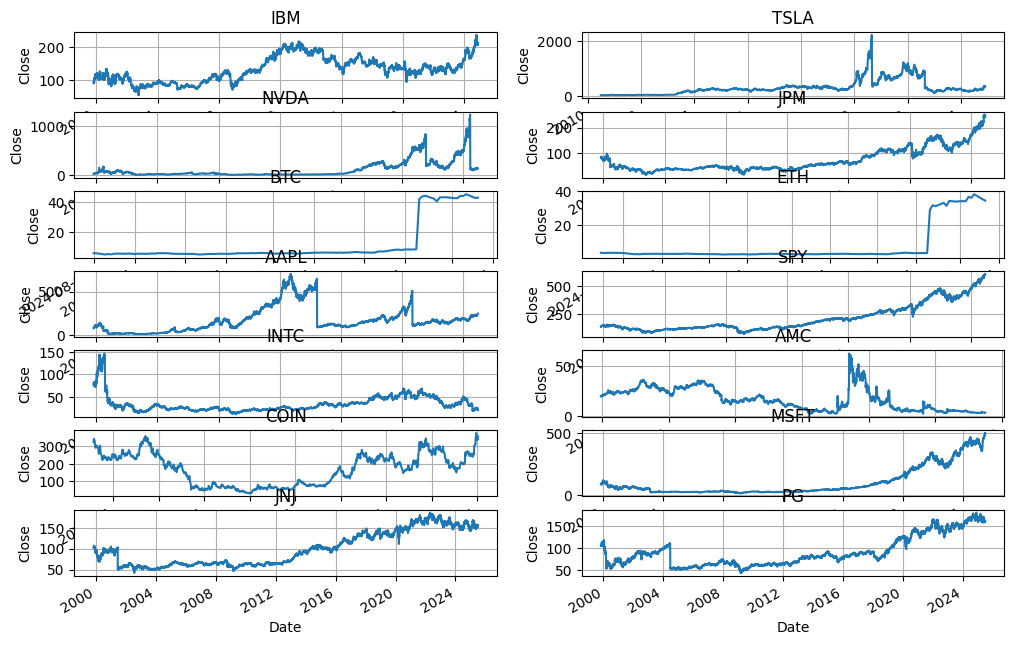

In [97]:
plot_stock_data(df_dict, feature='close')

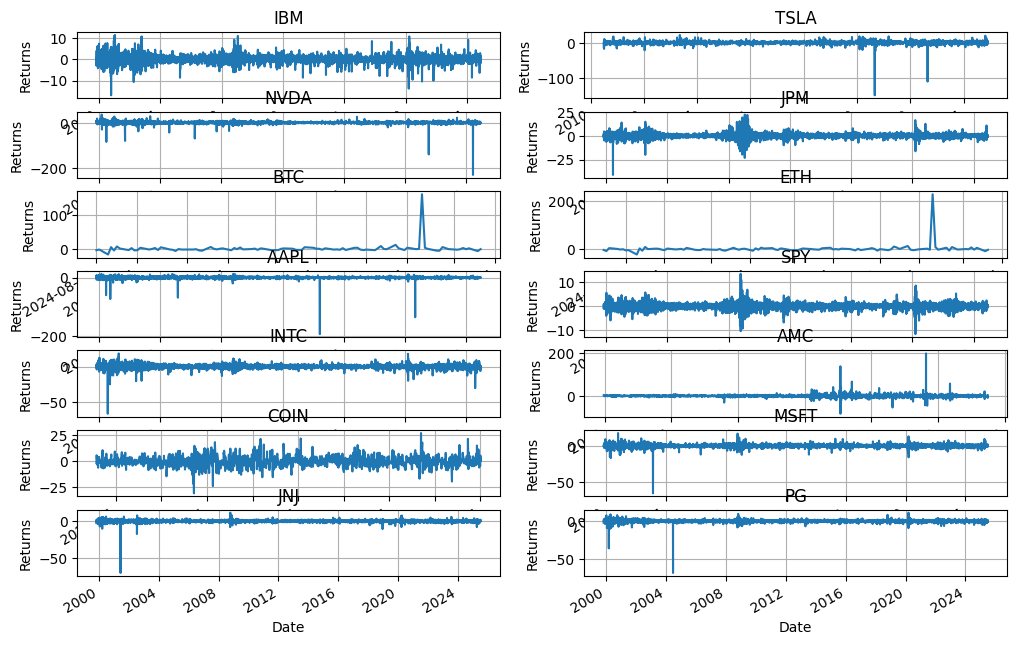

In [98]:
plot_stock_data(df_dict, feature='returns')

In [184]:
vol_cluster_stocks=['IBM','JPM','SPY','COIN']

In [185]:
df_vol_stocks = {stock: df_dict[stock] for stock in vol_cluster_stocks}

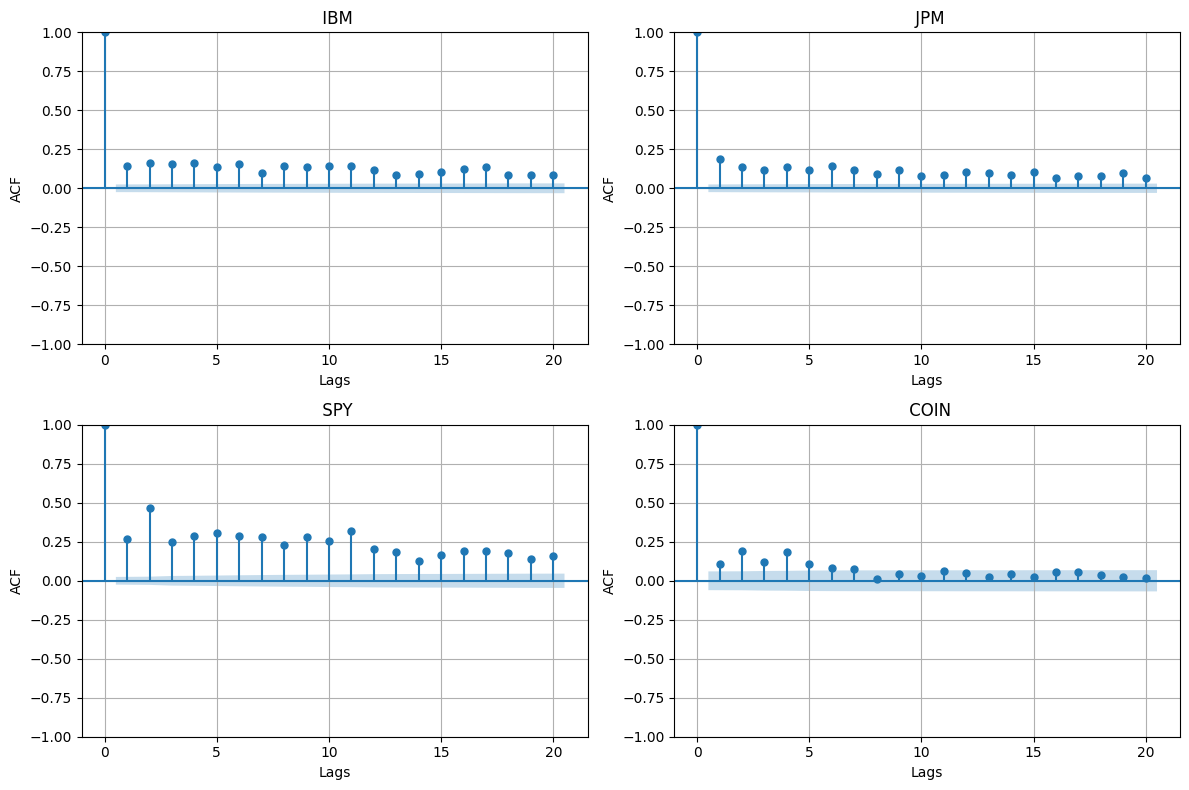

In [186]:
plot_stock_acf(df_vol_stocks, lags=20)

In [137]:
def acf_score(df, lags=10):
    acf_scores = {}
    for stock in df:
        acf_values = acf(df[stock]['returns']**2, nlags=lags)
        acf_scores[stock] = np.sum(np.abs(acf_values))
    return acf_scores

In [138]:
acf_scores = acf_score(df_dict, lags=10)

In [139]:
df_acf_score=pd.DataFrame(acf_scores.items(), columns=['Stock', 'ACF Score']).sort_values(by='ACF Score', ascending=False).set_index('Stock')

In [140]:
df_acf_score

,ACF Score
Stock,
SPY,3.910568
IBM,2.433446
JPM,2.247925
COIN,1.947807
AMC,1.296644
INTC,1.147597
BTC,1.111391
ETH,1.104008
MSFT,1.059634


# GARCH Walk Forward

In [147]:
class GARCHWalkForward:
    def __init__(self, stock_data, train_size=0.8):
        self.stock_data = stock_data
        self.train_size = train_size

    def train_test_split(self):
        cutoff = int(len(self.stock_data) * self.train_size)
        y_test = self.stock_data["returns"].iloc[cutoff:]
        return y_test
    
    def fit_garch(self):
        y_test = self.train_test_split()
        w_fwd_pred =[]
        for i in range(len(y_test)):
            y_train = self.stock_data["returns"].iloc[1:-(len(y_test)-i)]
            model = arch_model(y_train, vol='EGARCH', p=1, q=1, rescale=False)
            res= model.fit(disp=0)
            params_dict = res.params.to_dict()
            forecasts = res.forecast(horizon=1)
            pred_vol = (forecasts.variance.values[-1,:][0])**0.5
            w_fwd_pred.append(pred_vol)
        return w_fwd_pred, params_dict
    
    def plot_results(self,  w_fwd_pred):
        y_test = self.train_test_split()
        w_fwd_vol= pd.Series(w_fwd_pred, index=y_test.index, name='Predicted Volatility')
        test_vol= self.stock_data['returns'].rolling(window=21).std().dropna()
        test_vol=test_vol.iloc[-len(y_test):]
        plt.figure(figsize=(12, 6))
        plt.plot(y_test.index, y_test, color='lightgray', label='Log Returns')
        plt.plot(y_test.index, w_fwd_vol, color='black', label='Predicted Volatility')
        plt.plot(test_vol.index, test_vol, color='red', label='Actual Volatility')
        plt.legend()
        plt.title('GARCH Model Walk Forward Prediction')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.show()

    def evaluate_model(self, w_fwd_pred):
        y_test = self.train_test_split()
        w_fwd_vol = pd.Series(w_fwd_pred, index=y_test.index, name='Predicted Volatility')
        test_vol = self.stock_data['returns'].rolling(window=21).std().dropna()
        test_vol = test_vol.iloc[-len(y_test):]
        
        r2 = r2_score(test_vol, w_fwd_vol)
        mae = mean_absolute_error(test_vol, w_fwd_vol)
        mse = mean_squared_error(test_vol, w_fwd_vol)
        
        print(f"R^2: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}")


# GARCH on volatility clustering stocks

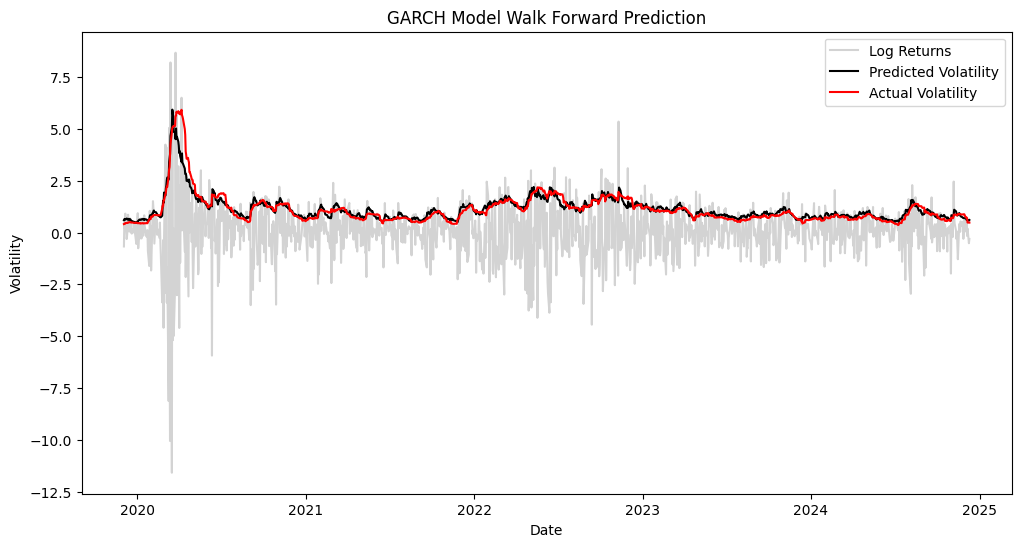

R^2: 0.8729, MAE: 0.1571, MSE: 0.0707


In [148]:
SPY_garch = GARCHWalkForward(df_dict['SPY'])
w_fwd_pred, params_dict = SPY_garch.fit_garch()
SPY_garch.plot_results(w_fwd_pred)
SPY_garch.evaluate_model(w_fwd_pred)

In [149]:
params_dict

{'mu': 0.07283885201895636,
 'omega': 0.009980052159672369,
 'alpha[1]': 0.24769998532942525,
 'beta[1]': 0.9716707197384307}

In [151]:
params_dict['alpha[1]']+params_dict['beta[1]']

1.219370705067856

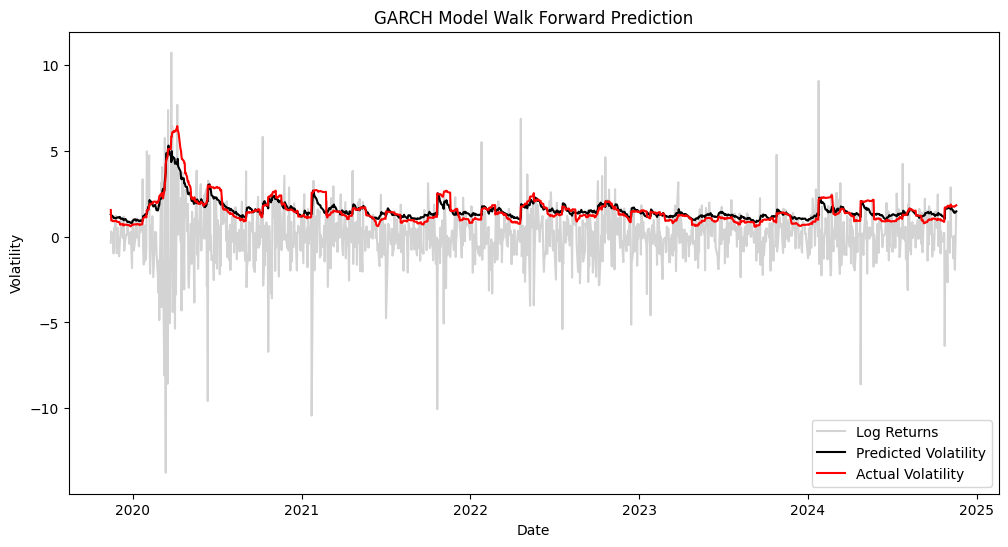

R^2: 0.8034, MAE: 0.2623, MSE: 0.1309


In [155]:
IBM_garch = GARCHWalkForward(df_dict['IBM'])
w_fwd_pred, params_dict = IBM_garch.fit_garch()
IBM_garch.plot_results(w_fwd_pred)
IBM_garch.evaluate_model(w_fwd_pred)

In [158]:
params_dict

{'mu': 0.03263726432341388,
 'omega': 0.03219331946226408,
 'alpha[1]': 0.1580626654976987,
 'beta[1]': 0.9731783129692304}

In [159]:
params_dict['alpha[1]']+params_dict['beta[1]']

1.131240978466929

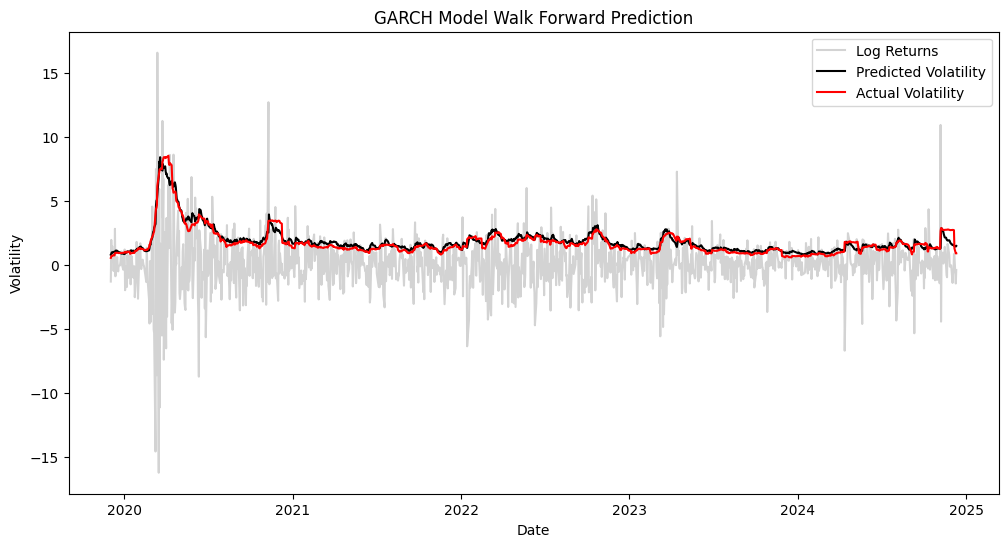

R^2: 0.9195, MAE: 0.2362, MSE: 0.0987


In [160]:
JPM_garch = GARCHWalkForward(df_dict['JPM'])
w_fwd_pred, params_dict = JPM_garch.fit_garch()
JPM_garch.plot_results(w_fwd_pred)
JPM_garch.evaluate_model(w_fwd_pred)

In [161]:
params_dict

{'mu': 0.06944996329810502,
 'omega': 0.022050560405149758,
 'alpha[1]': 0.18084068337995077,
 'beta[1]': 0.9908038493429069}

In [162]:
params_dict['alpha[1]']+params_dict['beta[1]']

1.1716445327228577

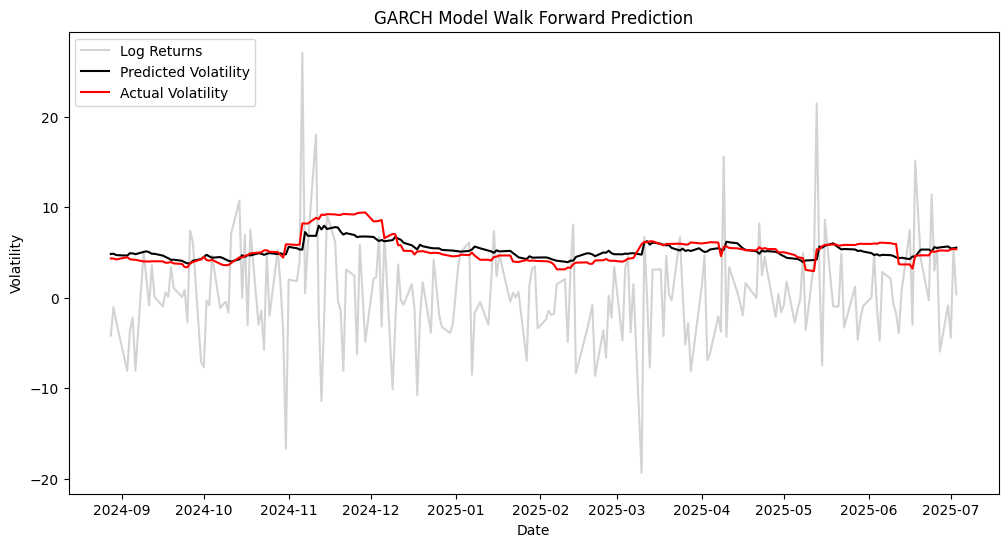

R^2: 0.6556, MAE: 0.6797, MSE: 0.7579


In [152]:
COIN_garch = GARCHWalkForward(df_dict['COIN'])
w_fwd_pred, params_dict = COIN_garch.fit_garch()
COIN_garch.plot_results(w_fwd_pred)
COIN_garch.evaluate_model(w_fwd_pred)

In [153]:
params_dict

{'mu': 0.04710965417883864,
 'omega': 0.06691868710005695,
 'alpha[1]': 0.11514753008392486,
 'beta[1]': 0.9813019261660293}

In [154]:
params_dict['alpha[1]']+params_dict['beta[1]']

1.096449456249954

# GARCH on stocks without volatility clustering

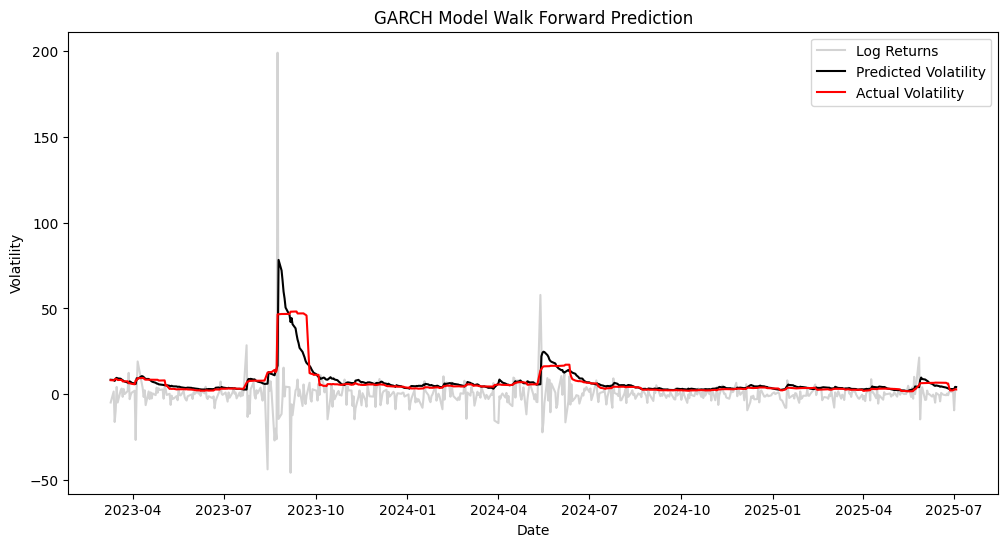

R^2: 0.7805, MAE: 1.6614, MSE: 15.6896


In [163]:
AMC_garch = GARCHWalkForward(df_dict['AMC'])
w_fwd_pred, params_dict = AMC_garch.fit_garch()
AMC_garch.plot_results(w_fwd_pred)
AMC_garch.evaluate_model(w_fwd_pred)

In [164]:
params_dict

{'mu': -0.08120954999611983,
 'omega': 0.06123803895182749,
 'alpha[1]': 0.2974372628617809,
 'beta[1]': 0.9927621702762858}

In [166]:
params_dict['alpha[1]']+params_dict['beta[1]']

1.2901994331380666

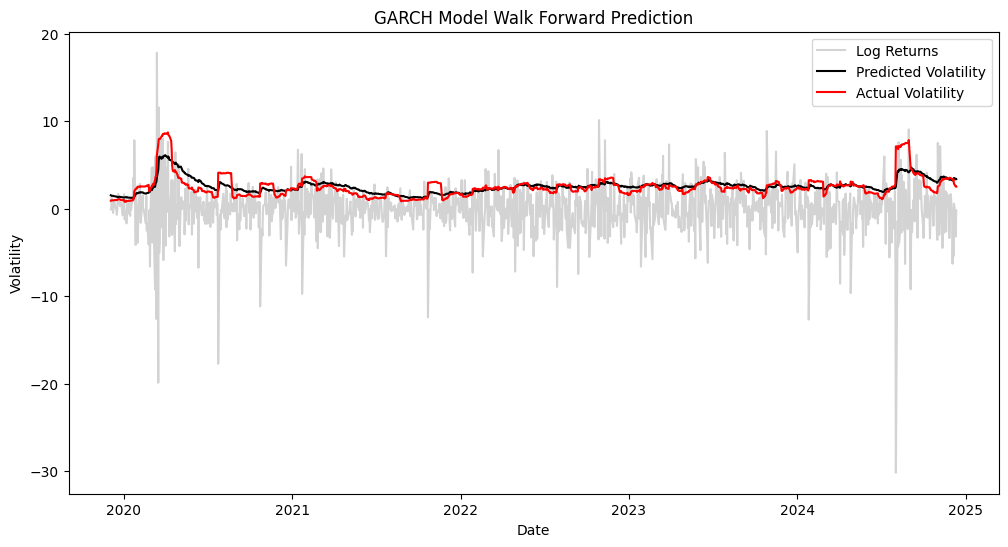

R^2: 0.6270, MAE: 0.5252, MSE: 0.5696


In [167]:
INTC_garch = GARCHWalkForward(df_dict['INTC'])
w_fwd_pred, params_dict = INTC_garch.fit_garch()
INTC_garch.plot_results(w_fwd_pred)
INTC_garch.evaluate_model(w_fwd_pred)

In [168]:
params_dict

{'mu': 0.010870803210052812,
 'omega': 0.01253294905026291,
 'alpha[1]': 0.08437348455065302,
 'beta[1]': 0.9972697759524309}

In [169]:
params_dict['alpha[1]']+params_dict['beta[1]']

1.081643260503084

/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


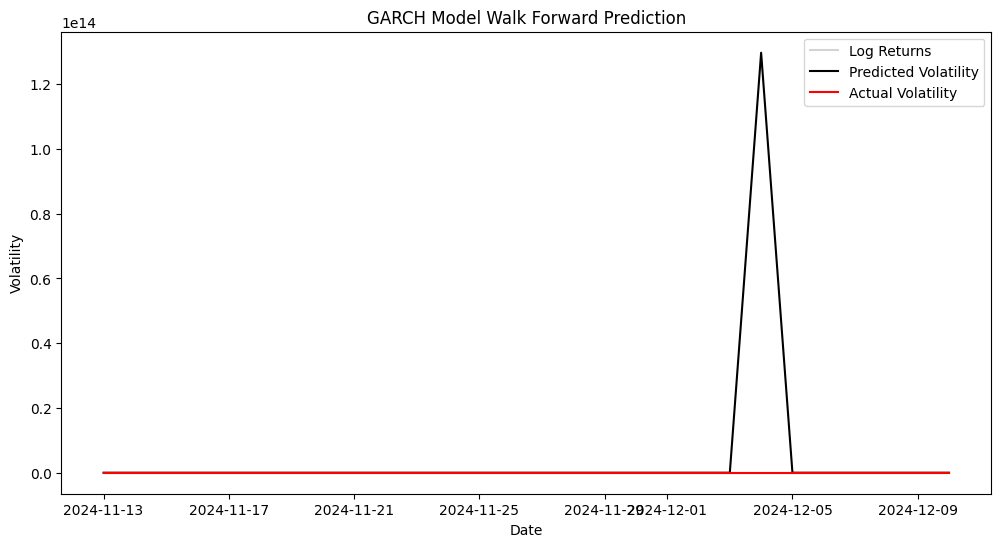

R^2: -4630006883104935601242112.0000, MAE: 6828195733145.5176, MSE: 885856743550538765769375744.0000


In [170]:
BTC_garch = GARCHWalkForward(df_dict['BTC'])
w_fwd_pred, params_dict = BTC_garch.fit_garch()
BTC_garch.plot_results(w_fwd_pred)
BTC_garch.evaluate_model(w_fwd_pred)

/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/ba

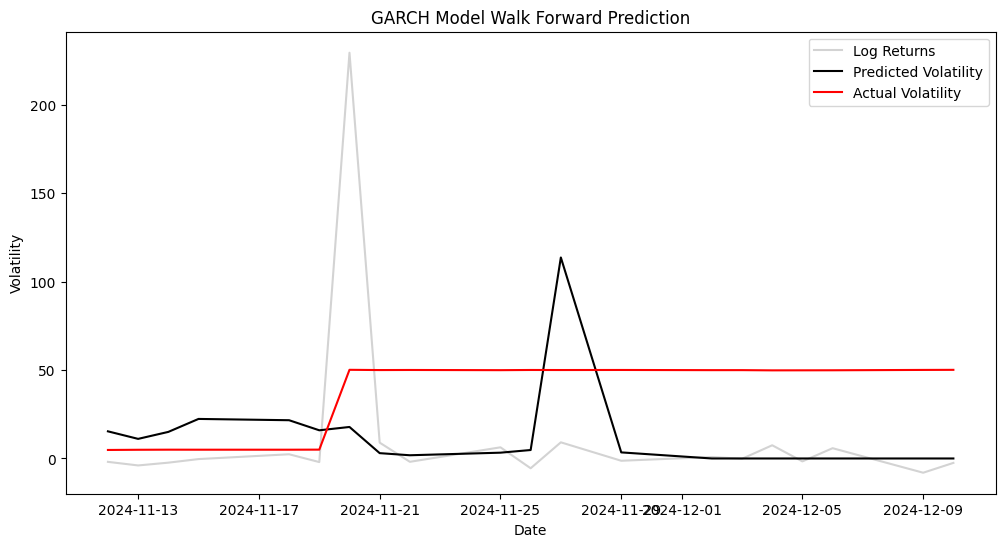

R^2: -3.0400, MAE: 37.5359, MSE: 1720.2980


In [179]:
ETH_garch = GARCHWalkForward(df_dict['ETH'])
w_fwd_pred, params_dict = ETH_garch.fit_garch()
ETH_garch.plot_results(w_fwd_pred)
ETH_garch.evaluate_model(w_fwd_pred)

In [180]:
params_dict

{'mu': 1.284896954760875,
 'omega': 0.23044702702486622,
 'alpha[1]': -0.6324728395071586,
 'beta[1]': 0.9156980337992295}

/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


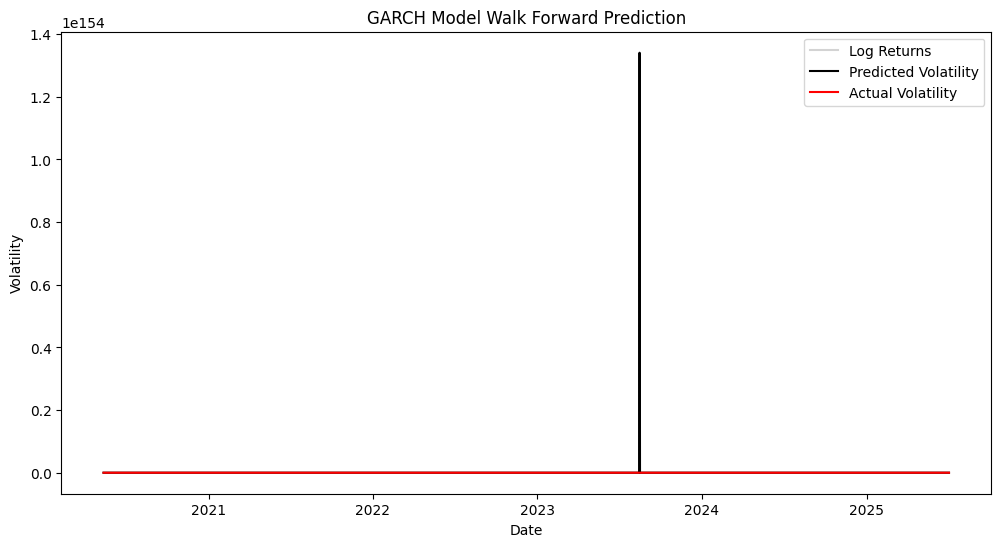

R^2: -1235670748404267094955178228741800167394436166231813434866914974249923636152164877309248630942624493584101972334058667181286037980407461955562453112835080652146909426798238457723832359718627369542307682685812498438558961370674651105922590616386087228132289800234378966163702774444625772233798938303112675328.0000, MAE: 10377560317292908869308492518156666439978084526032100518850744798747788199946887644438395625881061466875056559715110421095458309463224215966510942781440.0000, MSE: 139140335515655820905741687208131145849935377937861726603599479572534506914644866402246866913996642451836691922712110720163943618490577915702501993350260968282977046696316353513285420645293929919756191131840236170683806758784892821527365752876240719663101345940487563337979455819319849982593736867389112320.0000


In [177]:
PG_GARCH = GARCHWalkForward(df_dict['PG'])
w_fwd_pred, params_dict = PG_GARCH.fit_garch()
PG_GARCH.plot_results(w_fwd_pred)
PG_GARCH.evaluate_model(w_fwd_pred)

In [178]:
params_dict

{'mu': -4.687995236273735e-08,
 'omega': 0.03101793766459627,
 'alpha[1]': 0.04875070109449917,
 'beta[1]': 0.9776066993419642}

In [ ]:
df_dict['PG']

,open,high,low,close,volume,returns
date,,,,,,
1999-11-02,107.800,108.40,106.000,106.00,2550100.0,-1.869213
1999-11-03,106.600,107.60,105.300,106.80,2503300.0,0.751883
1999-11-04,107.300,107.40,104.000,105.30,2124000.0,-1.414451
1999-11-05,106.000,106.80,105.500,105.90,1653100.0,0.568183
1999-11-08,105.900,108.80,105.600,108.60,1654300.0,2.517615
...,...,...,...,...,...,...
2025-06-27,158.680,160.13,158.290,159.86,19256955.0,0.772399
2025-06-30,159.260,159.90,158.130,159.32,11238201.0,-0.338367
2025-07-01,159.880,162.53,159.380,161.22,10664891.0,1.185513


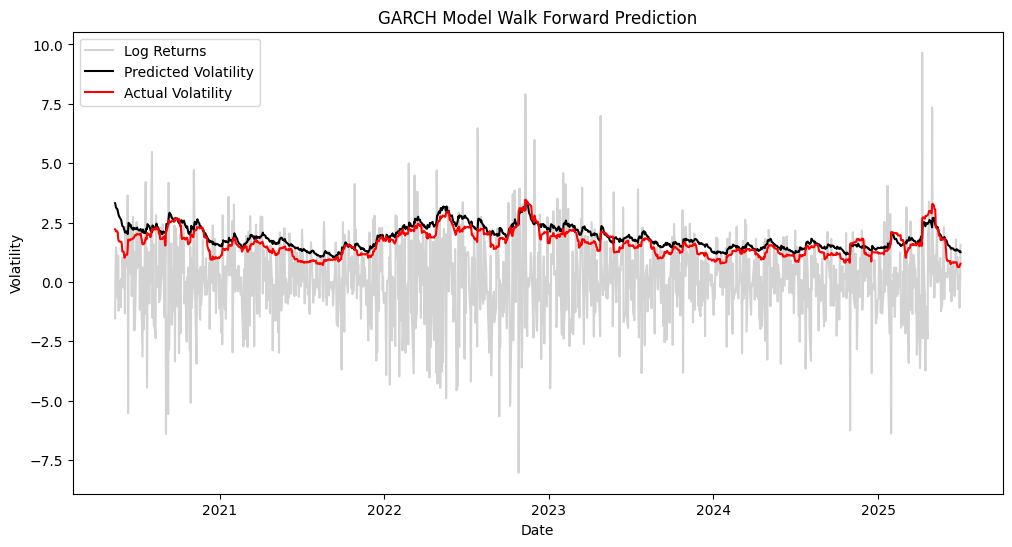

R^2: 0.5757, MAE: 0.2978, MSE: 0.1226


In [174]:
MSFT_garch = GARCHWalkForward(df_dict['MSFT'])
w_fwd_pred, params_dict = MSFT_garch.fit_garch()
MSFT_garch.plot_results(w_fwd_pred)
MSFT_garch.evaluate_model(w_fwd_pred)

In [175]:
params_dict

{'mu': 0.07702265323782516,
 'omega': 0.024294083598870368,
 'alpha[1]': 0.129180979204356,
 'beta[1]': 0.9920891656756704}

In [176]:
params_dict['alpha[1]']+params_dict['beta[1]']

1.1212701448800264

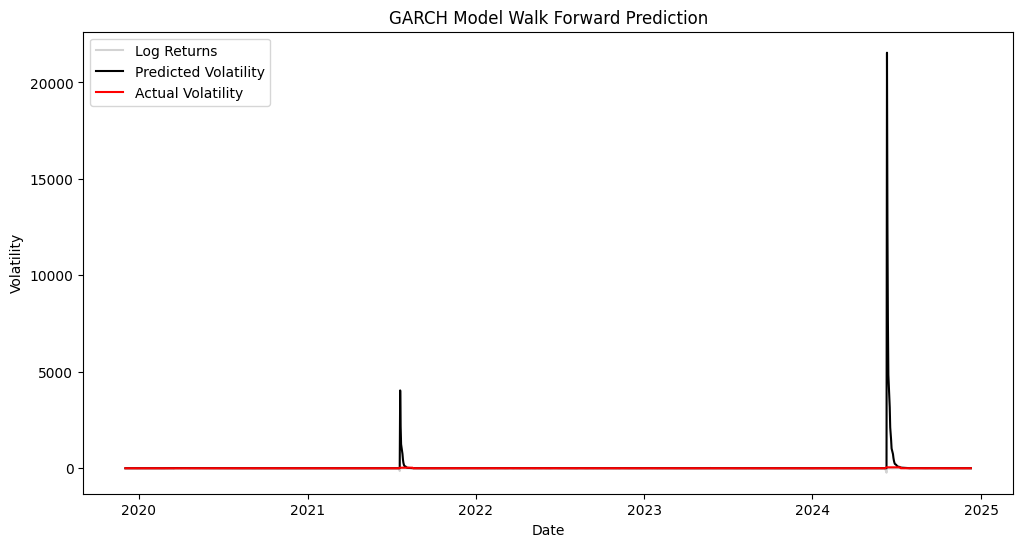

R^2: -11840.7547, MAE: 53.0991, MSE: 585084.4946


In [187]:
NVDA_garch = GARCHWalkForward(df_dict['NVDA'])
w_fwd_pred, params_dict = NVDA_garch.fit_garch()
NVDA_garch.plot_results(w_fwd_pred)
NVDA_garch.evaluate_model(w_fwd_pred)